## 02 - Sampling the Imaginary

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-01-30T20:06:41.719061+04:00

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.31.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pymc       : 5.20.0
statsmodels: 0.14.4
arviz      : 0.20.0
pandas     : 2.2.3
matplotlib : 3.10.0
xarray     : 2025.1.1
numpy      : 1.26.4
scipy      : 1.15.1
watermark  : 2.5.0



#### Introduction

Suppose there is a blood test that correctly detects vampirism 95% of the time. In more precise and mathematical notation, $P(\text{positive test result}\mid\text{vampire})=0.95$. It’s a very accurate test, nearly always catching real vampires. It also make mistakes, though, in the form of **false positives**. One percent of the time, it incorrectly diagnoses normal people as vampires, $P(\text{positive test result}\mid\text{mortal})=0.01$. The final bit of information we are told is that vampires are rather rare, being only 0.1% of the population, implying $P(\text{vampire})=0.001$. Suppose now that someone tests positive for vampirism. What’s the probability that he or she is a bloodsucking immortal?

|                  | Vampire | Mortal  |
|------------------|---------|--------|
| Test Vampire     | 0.95    | 0.01   |
| Test Not Vampire | 0.05    | 0.99   |

$$P(\text{Vampire} \mid \text{Positive}) = \frac{P(\text{Positive} \mid \text{Vampire})P(\text{Vampire})}{P(\text{Positive})}$$

- $P(\text{Vampire}) = 0.001$
- $P(\text{Positive} \mid \text{Vampire}) = 0.95$
- $P(\text{Positive}) = P(\text{Positive} \mid \text{Vampire})P(\text{Vampire}) + P(\text{Positive} \mid \text{Mortal})P(\text{Mortal})$
- $P(\text{Positive} \mid \text{Mortal}) = 0.01$ (False Positive)
- $P(\text{Positive}) = (0.95)(0.001) + (0.01)(0.999)$

That corresponds to an 8.7% chance that the suspect is actually a vampire.

In [2]:
pr_positive_vampire = 0.95
pr_positive_mortal = 0.01
pr_vampire = 0.001
pr_positive = pr_positive_vampire * pr_vampire + \
              pr_positive_mortal * (1 - pr_vampire)

pr_vampire_positive = pr_positive_vampire * pr_vampire / pr_positive

print(f'P(Vampire | Positive) = {pr_vampire_positive:.2%}')

P(Vampire | Positive) = 8.68%


Most people find this result counterintuitive. And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing, criminal profiling, and even statistical significance testing. Whenever the condition of interest is very rare, having a test that finds all the true cases is still no guarantee that a positive result carries much information at all. The reason is that **most positive results are false positives, even when all the true positives are detected correctly**.

Suppose that instead of reporting probabilities, as before, we are told the following:
1) In a population of 100,000 people, 100 of them are vampires.
2) Of the 100 who are vampires, 95 of them will test positive for vampirism.
3) Of the 99,900 mortals, 999 of them will test positive for vampirism.

If we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Now we can just count up the number of people who test positive: $95 +999 =1094$. Out of these 1094 positive tests, 95 of them are real vampires, so that implies:
$$P(\text{Vampire} \mid \text{Positive}) = \frac{95}{1094} \approx 0.087$$

It’s exactly the same answer as before, but without a seemingly arbitrary rule. The second presentation of the problem, using counts rather than probabilities, is often called the *frequency format* or *natural frequencies*. 

In this notebook we exploit the intuitive frequency format by taking the probability distributions and sampling from them to produce counts. The posterior distribution is a probability distribution. And like all probability distributions, we can imagine drawing samples from it. The sampled events in this case are parameter values. Most parameters have no exact empirical realization. The Bayesian formalism treats parameter distributions as relative plausibility, not as any physical random process. In any event, randomness is always a property of information, never of the real world. But inside the computer, parameters are just as empirical as the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines the expected frequency that different parameter values will appear, once we start plucking parameters out of it.

**Why statistics can’t save bad science**

The vampirism example has the same logical structure as many different **signal detection problems**: (1) There is some binary state that is hidden from us; (2) we observe an imperfect cue of the hidden state; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on our uncertainty. 

Scientific inference is sometimes framed in similar terms: (1) An hypothesis is either true or false; (2) we get a statistical cue of the hypothesis’ falsity; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on the status of the hypothesis. It’s the third step that is hardly ever done. But let’s consider a toy example. Suppose the probability of a positive finding, when an hypothesis is true, is $P(\text{sig}|\text{true})=0.95$. That’s the power of the test. Suppose that the probability of a positive finding, when an hypothesis is false, is $P(\text{sig}|\text{false})=0.05$. That’s the false-positive rate, like the 5% of conventional significance testing. Finally, we have to state the base rate at which hypotheses are true. Suppose for example that 1 in every 100 hypotheses turns out to be true. Then $P(\text{true})=0.01$. No one knows this value, but the history of science suggests it’s small.

Now compute the posterior:
$$P(\text{true} \mid \text{pos}) = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos})} = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos} \mid \text{true})P(\text{true}) + P(\text{pos} \mid \text{false})P(\text{false})}$$

Plug in the appropriate values, and the answer is approximately $P(\text{true}|\text{pos})=0.16$. So a positive finding corresponds to a 16% chance that the hypothesis is true. This is the same low base-rate phenomenon that applies in medical (and vampire) testing. You can shrink the false-positive rate to 1% and get this posterior probability up to 0.5, only as good as a coin flip. The most important thing to do is to improve the base rate, $P(\text{true})$, and that requires thinking, not testing.

In [3]:
pr_positive_true = 0.95 
pr_true = 0.01
pr_positive_false = 0.05
pr_positive = pr_positive_true * pr_true + pr_positive_false * (1 - pr_true)

pr_true_positive = (pr_positive_true * pr_true) / pr_positive

print(f'P(True | Positive) = {pr_true_positive:.2%}')

P(True | Positive) = 16.10%


Many are uncomfortable with integral calculus. Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem. An integral in a typical Bayesian context is just the total probability in some interval. That can be a challenging calculus problem. But once you have samples from the probability distribution, it’s just a matter of counting values in the interval. An empirical attack on the posterior allows on to ask and answer more questions about the model, without relying upon a captive mathematician. For this reason, it is easier and more intuitive to work with samples from the posterior, than to work with probabilities and integrals directly.

Some of the most capable methods of computing the posterior produce nothing but samples. Many of these methods are variants of Markov chain Monte Carlo techniques.

#### Sampling from a Grid-Approximation Posterior

The below code computes the posterior for a model using grid approximation. Remember, the posterior here means the probability of $p$ conditional on the data.

In [4]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(1, grid_points)

def binom_post_grid_approx(prior_func, grid_points=5, k=6, n=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    k (int): Number of successes
                    n (int): Number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    likelihood (numpy.array): array of likelihood at each point in the grid
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(k, n, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, likelihood, posterior

In [5]:
def beta_post_approx(grid_points=5, k=6, n=9, alpha_prior=1, beta_prior=1):
    """
    Beta posterior approximation with uniform prior.

            Parameters:
                    grid_points (int): Number of points in the prior grid
                    k (int): Number of successes
                    n (int): Number of tosses/trials
                    alpha_prior (int): Shape parameter 1 for the beta prior (default is 1 for uniform prior)
                    beta_prior (int): Shape parameter 2 for the beta prior (default is 1 for uniform prior)

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)
    
    alpha = k + alpha_prior  # Beta shape parameter 1
    beta = n - k + beta_prior  # Beta shape parameter 2    

    # compute likelihood at each point in the grid
    posterior = stats.beta.pdf(p_grid, alpha, beta)

    return p_grid, posterior

In [6]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=9)

# np.random.seed(10)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)
samples

array([0.67367367, 0.81281281, 0.7957958 , ..., 0.55855856, 0.25225225,
       0.53653654])

Now we wish to draw 10,000 samples from this posterior. Imagine the posterior is a bucket full of parameter values, numbers such as 0.1, 0.7, 0.5, 1, etc. Within the bucket, each value exists in proportion to its posterior probability, such that values near the peak are much more common than those in the tails. We’re going to scoop out 10,000 values from the bucket. Provided the bucket is well mixed, the resulting samples will have the same proportions as the exact posterior density. Therefore the individual values of $p$ will appear in our samples in proportion to the posterior plausibility of each value.

The workhorse here is `np.random.choice`, which randomly pulls values from a vector. The vector in this case is `p_grid`, the grid of parameter values. The probability of each value is given by `posterior`, which we computed just above.

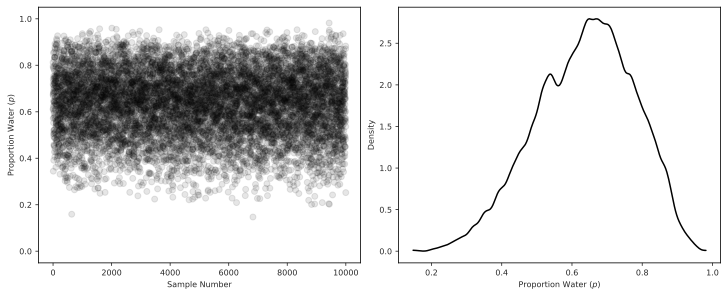

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(samples, 'ko', alpha=0.1)
ax[0].set_xlabel('Sample Number')
ax[0].set_ylabel('Proportion Water ($p$)')
ax[0].set_ylim(-0.05,1.05)
ax[0].spines[['right', 'top']].set_visible(True)
az.plot_kde(samples, plot_kwargs={'color': 'black', 'linestyle': '-'}, ax=ax[1])
ax[1].set_xlabel('Proportion Water ($p$)')
ax[1].set_ylabel('Density')
ax[1].spines[['right', 'top']].set_visible(True);

**Sampling parameter values from the posterior distribution**. Left: 10,000 samples from the posterior implied by the globe tossing data and model. Right: The density of samples (vertical) at each parameter value (horizontal).

In this plot, it’s as if you are flying over the posterior distribution, looking down on it. There are many more samples from the dense region near 0.6 and very few samples below 0.25. On the right, the plot shows the density estimate computed from these samples.

You can see that the estimated density is very similar to ideal posterior you computed via grid approximation. If you draw even more samples, maybe 1e5 or 1e6, the density estimate will get more and more similar to the ideal.

All you’ve done so far is crudely replicate the posterior density you had already computed. That isn’t of much value. But next it is time to use these samples to describe and understand the posterior. That is of great value.

#### Sampling to Summarize

Once your model produces a posterior distribution, the model’s work is done. But your work has just begun. It is necessary to summarize and interpret the posterior distribution. Exactly how it is summarized depends upon your purpose. But common questions include:

- How much posterior probability lies below some parameter value?
- How much posterior probability lies between two parameter values?
- Which parameter value marks the lower 5% of the posterior probability?
- Which range of parameter values contains 90% of the posterior probability?
- Which parameter value has highest posterior probability?

These simple questions can be usefully divided into questions about (1) intervals of **defined boundaries**, (2) questions about intervals of **defined probability mass**, and (3) questions about **point estimates**. We’ll see how to approach these questions using samples from the posterior.

##### Intervals of Defined Boundaries

Suppose I you are asked for the posterior probability that the proportion of water is less than 0.5. Using the grid-approximate posterior, you can just add up all of the probabilities, where the corresponding parameter value is less than 0.5:

In [8]:
# add up posterior probability where p < 0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

In [9]:
# Parameters for the Beta distribution
k = 6  # Number of successes
n = 9  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

# Theoretical - Probability density function
stats.beta.cdf(0.5, alpha, beta)

0.171875

So about 17% of the posterior probability is below 0.5. Couldn’t be easier. But since grid approximation isn’t practical in general, it won’t always be so easy. Once there is more than one parameter in the posterior distribution, even this simple sum is no longer very simple.

Let’s see how to perform the same calculation, using samples from the posterior. This approach does generalize to complex models with many parameters, and so you can use it everywhere. All you have to do is similarly add up all of the samples below 0.5, but also divide the resulting count by the total number of samples. In other words, find the frequency of parameter values below 0.5:

In [10]:
np.sum(samples < 0.5) / 1e4

0.1722

And that’s nearly the same answer as the grid approximation provided, although your answer will not be exactly the same, because the exact samples you drew from the posterior will be different. This region is shown in the upper-left plot below. 

Using the same approach, you can ask how much posterior probability lies between 0.5 and 0.75:

In [11]:
np.sum(posterior[(p_grid > 0.5) & (p_grid < 0.75)])

0.6045851774160315

In [12]:
# Theoretical - Interval Probability density function
stats.beta.cdf(0.75, alpha, beta) - stats.beta.cdf(0.5, alpha, beta)

0.6040000915527344

In [13]:
np.sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6017

So about 61% of the posterior probability lies between 0.5 and 0.75. This region is shown in the upper-right plot below.

##### Intervals of Defined Mass

It is more common to see scientific journals reporting an interval of defined mass, usually known as a **confidence interval**. An interval of posterior probability, such as the ones we are working with, may instead be called a **credible interval**. We’re going to call it a **compatibility interval** instead, in order to avoid the unwarranted implications of “confidence” and “credibility.” What the interval indicates is a range of parameter values compatible with the model and data. The model and data themselves may not inspire confidence, in which case the interval will not either.

These posterior intervals report two parameter values that contain between them a specified amount of posterior probability, a **probability mass**. For this type of interval, it is easier to find the answer by using samples from the posterior than by using a grid approximation. Suppose for example you want to know the boundaries of the lower 80% posterior probability. You know this interval starts at $p=0$. To find out where it stops, think of the samples as data and ask where the 80th percentile lies.

In [14]:
np.quantile(samples, q=0.8)

0.7627627627627628

In [15]:
cum_density_posterior = np.cumsum(posterior)
i_idx = np.searchsorted(cum_density_posterior, 0.8, side='right')
p_grid[i_idx]

0.7607607607607607

In [16]:
stats.beta.ppf(0.8, alpha, beta)

0.7605587778957529

Similarly, the middle 80% interval lies between the 10th percentile and the 90th percentile. These boundaries are found using the same approach.

In [17]:
np.quantile(samples, q=[0.1, 0.9])

array([0.44644645, 0.81581582])

In [18]:
stats.beta.interval(0.8, alpha, beta)

(0.4482691676164009, 0.8124377033526619)

In [19]:
cum_density_posterior = np.cumsum(posterior)
i_start_idx = np.searchsorted(cum_density_posterior, 0.1, side='right')
i_end_idx = np.searchsorted(cum_density_posterior, 0.9, side='right')
p_grid[i_start_idx], p_grid[i_end_idx]

(0.44844844844844844, 0.8128128128128128)

In [20]:
def compute_mass_interval(p_grid, posterior, i_start, i_end):
    """
    Compute the interval bounds and indices for a given mass interval.

    Parameters:
        p_grid (np.array): The grid of parameter values.
        posterior (np.array): The posterior probabilities corresponding to p_grid. 
                              Ensure the posterior is normalized
        i_start (float): The lower quantile (e.g., 0.1 for 10%).
        i_end (float): The upper quantile (e.g., 0.9 for 90%).

    Returns:
        i_start (float): The lower bound of the interval.
        i_end (float): The upper bound of the interval.
        i_indices (np.array): Boolean array indicating the indices of p_grid within the interval.
    """
    
    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(posterior)
    
    # Find the indices corresponding to the quantiles
    i_start_idx = np.searchsorted(cdf, i_start, side='right')
    i_end_idx = np.searchsorted(cdf, i_end, side='right')
    
    # Get the x-values corresponding to these indices
    i_start = p_grid[i_start_idx]
    i_end = p_grid[i_end_idx]
    
    return i_start, i_end

In [21]:
def compute_hdi(p_grid, posterior, hdi_prob=0.95):
    """
    Compute the Highest Density Interval (HDI) from grid of parameter values and its posterior.

    Parameters:
        p_grid (np.array): The grid of parameter values.
        posterior (np.array): The posterior probabilities corresponding to p_grid.
                              Ensure the posterior is normalized.
        hdi_prob (float): The probability mass to include in the HDI (e.g., 0.95 for 95% HDI).

    Returns:
        hdi_min (float): The lower bound of the HDI.
        hdi_max (float): The upper bound of the HDI.
    """
    
    # Sort the posterior and p_grid in descending order of posterior density
    sorted_indices = np.argsort(posterior)[::-1]
    sorted_posterior = posterior[sorted_indices]
    sorted_p_grid = p_grid[sorted_indices]
    
    # Compute the cumulative sum of the sorted posterior
    cumulative_posterior = np.cumsum(sorted_posterior)
    
    # Find the smallest set of points that contain the desired probability mass
    n_points = np.argmax(cumulative_posterior >= hdi_prob) + 1
    
    # Get the corresponding p_grid values for the HDI
    hdi_p_grid = sorted_p_grid[:n_points]
    
    # The HDI is the smallest interval in p_grid that contains these points
    hdi_min = np.min(hdi_p_grid)
    hdi_max = np.max(hdi_p_grid)
    
    return hdi_min, hdi_max

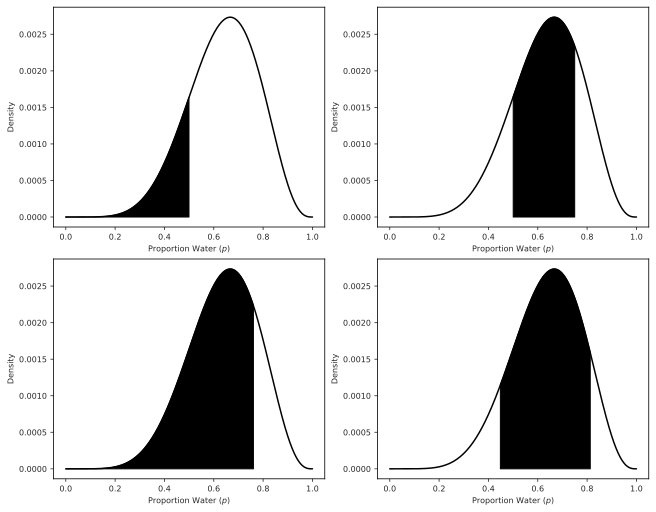

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
intervals = [(0, 0.5001), 
             (0.5, 0.7501), 
             (0.0, 0.8), 
             (0.1, 0.9)]
for ii in range(4):
    ax = axs[ii // 2][ii % 2]
    ax.plot(p_grid, posterior, color='k')
    i_start, i_end = intervals[ii]
    if ii < 2:
        # Intervals of defined boundaries 
        i_indices = (p_grid >= i_start) & (p_grid <= i_end)        
    else:
        # Intervals of defined mass
        i_start, i_end = compute_mass_interval(p_grid, posterior, i_start, i_end)
        # Get the indices for the x-axis values within the interval
        i_indices = (p_grid >= i_start) & (p_grid <= i_end)
    ax.fill_between(p_grid[i_indices], y1=0, y2=posterior[i_indices], color='k')
    ax.set_xlabel('Proportion Water ($p$)')
    ax.set_ylabel('Density')
    ax.spines[['right', 'top']].set_visible(True)

Two kinds of posterior interval. Top row: *Intervals of defined boundaries*. Top-left: The black area is the posterior probability below a parameter value of 0.5. Top-right: The posterior probability between 0.5 and 0.75. Bottom row: *Intervals of defined mass*. Bottom-left: Lower 80% posterior probability exists below a parameter value of about 0.76. Bottom-right: Middle 80% posterior probability lies between the 10% and 90% quantiles.

Intervals of this sort, which **assign equal probability mass to each tail**, are very common in the scientific literature. We’ll call them **percentile intervals (PI)**. These intervals do a good job of communicating the shape of a distribution, as long as the distribution isn’t too asymmetrical. But in terms of supporting inferences about which parameters are consistent with the data, they are not perfect. Consider the posterior distribution and different intervals below. This posterior is consistent with observing three waters in three tosses and a uniform (flat) prior. It is highly skewed, having its maximum value at the boundary, $p =1$. You can compute it, via grid approximation, with:

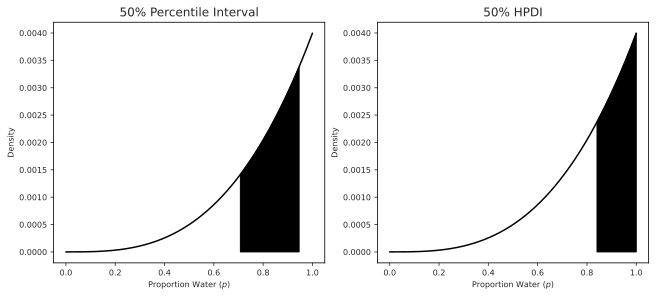

In [23]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, k=3, n=3)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
intervals = [(0.25, 0.8), 
             (0.5, 0.9999)]
title = ['50% Percentile Interval', '50% HPDI']
for ii in range(2):
    ax = axs[ii]
    ax.plot(p_grid, posterior, color='k')
    
    i_start, i_end = compute_mass_interval(p_grid, posterior, intervals[ii][0], intervals[ii][1])
    i_indices = (p_grid >= i_start) & (p_grid <= i_end)
    
    ax.fill_between(p_grid[i_indices], y1=0, y2=posterior[i_indices], color='k')
    ax.set_xlabel('Proportion Water ($p$)')
    ax.set_ylabel('Density')
    ax.set_title(title[ii])
    ax.spines[['right', 'top']].set_visible(True)

The difference between percentile and highest posterior density compatibility intervals. The posterior density here corresponds to a flat prior and observing three water samples in three total tosses of the globe. Left: 50% percentile interval. This interval assigns equal mass (25%) to both the left and right tail. As a result, it omits the most probable parameter value, $p=1$. Right: 50% highest posterior density interval, HPDI. This interval finds the narrowest region with 50% of the posterior probability. Such a region always includes the most probable parameter value.

The 50% percentile compatibility interval is shaded. You can conveniently compute this from the samples by computing the cumulative density function or by using `np.percentile`. 

In [24]:
# Compute from posterior
compute_mass_interval(p_grid, posterior, 0.25, 0.75)

(0.7077077077077077, 0.9309309309309309)

In [25]:
# Theoretical Interval
# Parameters for the Beta distribution
k = 3  # Number of successes
n = 3  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

stats.beta.interval(0.5, a=alpha, b=beta)

(0.7071067811865476, 0.9306048591020996)

In [26]:
# Compute from sample
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.7047047 , 0.93193193])

This interval assigns 25% of the probability mass above and below the interval. So it provides the central 50% probability. But in this example, it ends up excluding the most probable parameter values, near p =1. So in terms of describing the shape of the posterior distribution—which is really all these intervals are asked to do—the percentile interval can be misleading.

In contrast, the right-hand plot displays the 50% **highest posterior density interval**  (HPDI). The HPDI is the narrowest interval containing the specified probability mass. If you think about it, there must be an infinite number of posterior intervals with the same mass. But if you want an interval that best represents the parameter values most consistent with the data, then you want the densest of these intervals. That’s what the HPDI is. Compute it from the samples with ArviZ's HDI function.

In [27]:
az.hdi(samples, hdi_prob=0.5)

array([0.84084084, 0.998999  ])

In [28]:
compute_hdi(p_grid, posterior, hdi_prob=0.5)

(0.8408408408408409, 1.0)

This interval captures the parameters with highest posterior probability, as well as being noticeably narrower: 0.16 in width rather than 0.23 for the percentile interval.`

So the HPDI has some advantages over the PI. But in most cases, these two types of interval are very similar. They only look so different in this case because the posterior distribution is highly skewed. If we instead used samples from the posterior distribution for six waters in nine tosses, these intervals would be nearly identical. When the posterior is bell shaped, it hardly matters which type of interval you use. 

In [29]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=9)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)

print('PI (sample) =', np.percentile(samples, [25, 75]))
print('HDPI (sample) =', az.hdi(samples, hdi_prob=0.5))
print('PI (posterior) =', compute_mass_interval(p_grid, posterior, 0.25, 0.75))
print('HDPI (posterior) =', compute_hdi(p_grid, posterior, hdi_prob=0.5))
print('PI (theoratical) =', stats.beta.interval(0.5, a=6+1, b=9 - 6 + 1))

print()
print('PI (sample) =', np.percentile(samples, [5, 95]))
print('HDPI (sample) =', az.hdi(samples, hdi_prob=0.95))
print('PI (posterior) =', compute_mass_interval(p_grid, posterior, 0.05, 0.95))
print('HDPI (posterior) =', compute_hdi(p_grid, posterior, hdi_prob=0.95))
print('PI (theoratical) =', stats.beta.interval(0.9, a=6+1, b=9 - 6 + 1))

PI (sample) = [0.54154154 0.74074074]
HDPI (sample) = [0.57657658 0.77277277]
PI (posterior) = (0.5425425425425425, 0.7387387387387387)
HDPI (posterior) = (0.5645645645645646, 0.7587587587587588)
PI (theoratical) = (0.5423038454251481, 0.7391494116737936)

PI (sample) = [0.39039039 0.84984985]
HDPI (sample) = [0.35935936 0.88788789]
PI (posterior) = (0.3933933933933934, 0.8498498498498498)
HDPI (posterior) = (0.36736736736736736, 0.8928928928928929)
PI (theoratical) = (0.39337578389458766, 0.84997175919332)


The HPDI also has some disadvantages. HPDI is more computationally intensive than PI and suffers from greater simulation variance, which is a fancy way of saying that it is sensitive to how many samples you draw from the posterior. It is also harder to understand and many scientific audiences will not appreciate its features, while they will immediately understand a percentile interval, as ordinary non-Bayesian intervals are typically interpreted (incorrectly) as percentile intervals.

Overall, if the choice of interval type makes a big difference, then you shouldn’t be using intervals to summarize the posterior. Remember, the entire posterior distribution is the Bayesian “estimate.” It summarizes the relative plausibilities of each possible value of the parameter. Intervals of the distribution are just helpful for summarizing it. If choice of interval leads to different inferences, then you’d be better off just plotting the entire posterior distribution.

##### Point Estimates

The third and final common summary task for the posterior is to produce point estimates of some kind. Given the entire posterior distribution, what value should you report? This seems like an innocent question, but it is difficult to answer. The Bayesian parameter estimate is precisely the entire posterior distribution, which is not a single number, but instead a **function that maps each unique parameter value onto a plausibility value**. So really the most important thing to note is that you don’t have to choose a point estimate. It’s hardly ever necessary and often harmful. It discards information.

But if you must produce a single point to summarize the posterior, you’ll have to ask and answer more questions. Consider the following example. Suppose again the globe tossing experiment in which we observe 3 waters out of 3 tosses, as in our plot above. Let’s consider three alternative point estimates. First, it is very common for scientists to report the parameter value with highest posterior probability, a **maximum a posteriori** (MAP) estimate. You can easily compute the MAP in this example:

In [30]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1000, k=3, n=3)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

In [31]:
p_grid[np.argmax(posterior)]

1.0

Or if you instead have samples from the posterior, you can still approximate the same point:

In [32]:
stats.mode(samples)[0]

0.986986986986987

In [33]:
# https://www.r-bloggers.com/2019/08/arguments-of-statsdensity/
# https://python.arviz.org/en/latest/api/generated/arviz.kde.html
# https://python.arviz.org/en/stable/_modules/arviz/stats/density_utils.html#kde
samples_grid, samples_pdf = az.kde(samples, bw_fct=0.01)
samples_grid[np.argmax(samples_pdf)]

0.9713219078453453

But why is this point, the mode, interesting? Why not report the posterior mean or median?

In [34]:
# Mean: The mean of the distribution is the expected value of p_grid weighted by the posterior
# Median: The median is the value of p_grid where the cumulative distribution function (CDF) reaches 0.5
mean = np.sum(p_grid * posterior)
median_idx = np.searchsorted(np.cumsum(posterior), 0.5, side='right')
median = p_grid[median_idx]

mean, median

(0.8004001333331997, 0.8408408408408409)

In [35]:
# Parameters for the Beta distribution
k = 3  # Number of successes
n = 3  # Number of trials
alpha = k + 1  # Beta shape parameter 1
beta = n - k + 1  # Beta shape parameter 2

# Theoretical mean
theoretical_mean = alpha / (alpha + beta)
print('Theoretical Mean =', stats.beta.mean(alpha,beta))

# Theoretical median
theoretical_median = stats.beta.ppf(0.5, alpha, beta)
print('Theoretical Median =', theoretical_median)

Theoretical Mean = 0.8
Theoretical Median = 0.8408964152537145


In [36]:
np.mean(samples), np.median(samples)

(0.8011435435435436, 0.8428428428428428)

These are also point estimates, and they also summarize the posterior. But all three—the mode (MAP), mean, and median—are different in this case. How can we choose? Plot below shows this posterior distribution and the locations of these point summaries.

##### Loss Function

One principled way to go beyond using the entire posterior as the estimate is to choose a **loss function**. A loss function is a rule that tells you the cost associated with using any particular point estimate. While statisticians and game theorists have long been interested in loss functions, and how Bayesian inference supports them, scientists hardly ever use them explicitly. The key insight is that *different loss functions imply different point estimates*.

Here’s an example to help us work through the procedure. Suppose I offer you a bet. Tell me which value of p, the proportion of water on the Earth, you think is correct. I will pay you \$100, if you get it exactly right. But I will subtract money from your gain, proportional to the distance of your decision from the correct value. Precisely, your loss is proportional to the absolute value of $d−p$, where $d$ is your decision and $p$ is the correct answer. We could change the precise dollar values involved, without changing the important aspects of this problem. What matters is that the loss is proportional to the distance of your decision from the true value.

Now once you have the posterior distribution in hand, how should you use it to maximize your expected winnings? It turns out that the parameter value that maximizes expected winnings (minimizes expected loss) is the median of the posterior distribution. Let’s calculate that fact, without using a mathematical proof.

Calculating expected loss for any given decision means **using the posterior to average over our uncertainty in the true value**. Of course we don’t know the true value, in most cases. But if we are going to use our model’s information about the parameter, that means using the entire posterior distribution. So suppose we decide $p=0.5$ will be our decision. Then the expected loss will be:

In [37]:
p = 0.5
np.sum(posterior*np.abs(p-p_grid))

0.31287518749981214

The symbols `posterior` and `p_grid` are the same ones we’ve been using throughout, containing the **posterior probabilities** and the **parameter values**, respectively. All the code above does is compute the weighted average loss, where each loss is weighted by its corresponding posterior probability. There’s a trick for repeating this calculation for every possible decision, using the function sapply.

In [38]:
# Method 1
loss = np.sum(posterior * np.abs(p_grid.reshape(-1,1) - p_grid), axis=1)

# Method 2
# loss = list(map(lambda d: sum(posterior * abs(d - p_grid)), p_grid))

# Method 3
# loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]

Now the symbol `loss` contains a list of loss values, one for each possible decision, corresponding the values in `p_grid`. From here, it’s easy to find the parameter value that minimizes the loss:

In [39]:
p_grid[np.argmin(loss)]

0.8408408408408409

And this is actually the **posterior median**, the parameter value that splits the posterior density such that half of the mass is above it and half below it. Try `np.median(samples)` for comparison. It may not be exactly the same value, due to sampling variation, but it will be close.

In [40]:
np.median(samples)

0.8428428428428428

So what are we to learn from all of this? In order to decide upon a *point estimate*, a single-value summary of the posterior distribution, we need to pick a loss function. Different loss functions nominate different point estimates. The two most common examples are the absolute loss as above, which leads to the median as the point estimate, and the quadratic loss $(d −p)^2$, which leads to the posterior mean (`np.mean(samples)`) as the point estimate. When the posterior distribution is symmetrical and normal-looking, then the median and mean converge to the same point, which relaxes some anxiety we might have about choosing a loss function. For the original globe tossing data (6 waters in 9 tosses), for example, the mean and median are barely different.

In [41]:
loss = np.sum(posterior * (p_grid.reshape(-1,1) - p_grid)**2, axis=1)
p_grid[np.argmin(loss)]

0.8008008008008007

In [42]:
np.mean(samples)

0.8011435435435436

In [43]:
def loss_function_median(p_grid, posterior):
    return np.sum(posterior * np.abs(p_grid.reshape(-1,1) - p_grid), axis=1)

def loss_function_mean(p_grid, posterior):
    return np.sum(posterior * (p_grid.reshape(-1,1) - p_grid)**2, axis=1)

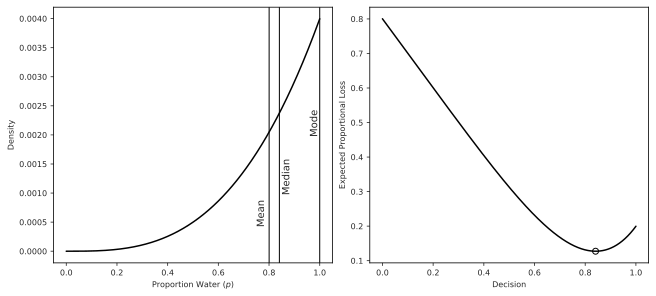

In [44]:
mode = p_grid[np.argmax(posterior)]
mean = np.sum(p_grid * posterior)
median_idx = np.searchsorted(np.cumsum(posterior), 0.5, side='right')
median = p_grid[median_idx]
loss = loss_function_median(p_grid, posterior)


_, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
ax.plot(p_grid, posterior, color='k')
ax.axvline(mean, color='k', linewidth=1)
ax.axvline(median, color='k', linewidth=1)
ax.axvline(mode, color='k', linewidth=1)
ax.text(x=0.75, y=0.00045, s='Mean', rotation=90)
ax.text(x=0.85, y=0.0010, s='Median', rotation=90)
ax.text(x=0.96, y=0.0020, s='Mode', rotation=90)
ax.set_xlabel('Proportion Water ($p$)')
ax.set_ylabel('Density')

ax = axs[1]
ax.plot(p_grid, loss, 'k')
ax.plot(p_grid[np.argmin(loss)], np.min(loss), 'o', color='k', markerfacecolor='none')
ax.set_xlabel('Decision')
ax.set_ylabel('Expected Proportional Loss')

for i in range(2):
    axs[i].spines[['right', 'top']].set_visible(True)

Point estimates and loss functions. 
- Left: Posterior distribution after observing 3 water in 3 tosses of the globe. Vertical lines show the locations of the mode, median, and mean. Each point implies a different loss function. 
- Right: Expected loss under the rule that loss is proportional to absolute distance of decision (horizontal axis) from the true value. The point marks the value of p that minimizes the expected loss, the posterior median.

In principle, the details of the applied context may demand a rather unique loss function. Consider a practical example like deciding whether or not to order an evacuation, based upon an estimate of hurricane wind speed. Damage to life and property increases very rapidly as wind speed increases. There are also costs to ordering an evacuation when none is needed, but these are much smaller. Therefore the implied loss function is highly **asymmetric**, rising sharply as true wind speed exceeds our guess, but rising only slowly as true wind speed falls below our guess. In this context, the optimal point estimate would tend to be larger than posterior mean or median. Moreover, the real issue is whether or not to order an evacuation. Producing a point estimate of wind speed may not be necessary at all.

#### Sampling to Simulate Prediction

Another common job for samples is to ease **simulation** of the model’s implied observations. Generating implied observations from a model is useful for at least four reasons:
1) **Model design**. We can sample not only from the posterior, but also from the prior. Seeing what the model expects, before the data arrive, is the best way to understand the implications of the prior. We’ll do a lot of this later, where there will be multiple parameters and so their joint implications are not always very clear.
2) **Model checking**. After a model is updated using data, it is worth simulating implied observations, to check both whether the fit worked correctly and to investigate model behavior.
3) **Software validation**. In order to be sure that our model fitting software is working, it helps to simulate observations under a known model and then attempt to recover the values of the parameters the data were simulated under.
4) **Research design**. If you can simulate observations from your hypothesis, then you can evaluate whether the research design can be effective. In a narrow sense, this means doing power analysis, but the possibilities are much broader.
5) **Forecasting**. Estimates can be used to simulate new predictions, for new cases and future observations. These forecasts can be useful as applied prediction, but also for model criticism and revision.

We’ll look at how to produce simulated observations and how to perform some simple model checks.

##### Dummy Data

Let’s summarize the globe tossing model that you’ve been working with. A fixed true proportion of water $p$ exists, and that is the target of our inference. Tossing the globe in the air and catching it produces observations of “water” and “land” that appear in proportion to $p$ and $1−p$, respectively.

Now note that these assumptions not only allow us to infer the plausibility of each possible value of $p$, after observation. These assumptions also allow us to **simulate the observations that the model implies**. They allow this, because **likelihood functions work in both directions**. Given a realized observation, the likelihood function says how plausible the observation is. And given only the parameters, the likelihood defines a distribution of possible observations that we can sample from, to simulate observation. In this way, Bayesian models are always **generative**, capable of simulating predictions. Many non-Bayesian models are also generative, but many are not.

We will call such simulated data **dummy data**, to indicate that it is a stand-in for actual data. With the globe tossing model, the dummy data arises from a binomial likelihood:

$$P(W \mid N,p) = \frac{N!}{W!(N-W)!}p^{W}(1-p)^{N-W}$$

where $W$ is an observed count of “water” and $N$ is the number of tosses. Suppose $N =2$, two tosses of the globe. Then there are only three possible observations: 0 water, 1 water, 2 water. You can quickly compute the probability of each, for any given value of $p$. Let’s use $p=0.7$, which is just about the true proportion of water on the Earth:

In [45]:
k = [0,1,2]
n = 2
p = 0.7
stats.binom.pmf(k=k, n=n, p=p)

array([0.09, 0.42, 0.49])

This means that there’s a 9% chance of observing $w =0$, a 42% chance of $w =1$, and a 49% chance of $w =2$. If you change the value of $p$, you’ll get a different distribution of implied observations.

Now we’re going to simulate observations, using these probabilities. This is done by sampling from the distribution just described above. You could use sample to do this, but Python's SciPy provides convenient sampling functions for all the ordinary probability distributions, like the binomial. So a single dummy data observation of $W$ can be sampled with:

In [46]:
stats.binom.rvs(n=n, p=p, size=1)

array([1])

That 1 means “1 water in 2 tosses.” The `rvs` method in `stats.binom` stands for “random variates.” It can also generate more than one simulation at a time. A set of 10 simulations can be made by:

In [47]:
stats.binom.rvs(n=n, p=p, size=10)

array([2, 1, 2, 2, 1, 1, 2, 1, 2, 0])

Let’s generate 100,000 dummy observations, just to verify that each value (0, 1, or 2) appears in proportion to its likelihood:

In [48]:
from prettytable import PrettyTable

n = 2
p = 0.7

dummy_w = stats.binom.rvs(n=n, p=p, size=int(1e5))
toss_count, total_counts = np.unique(dummy_w, return_counts=True)

table = PrettyTable()
table.field_names = np.append(['W'], toss_count)
table.add_row(np.append(['Total Count'], total_counts))
table.add_row(np.append(['Proportion'], total_counts/1e5))
table

W,0,1,2
Total Count,9011,42163,48826
Proportion,0.09011,0.42163,0.48826


These values are very close to the analytically calculated likelihoods calculated earlier with `stats.binom.pmf`. You will see slightly different values, due to simulation variance. Execute the code above multiple times, to see how the exact realized frequencies fluctuate from simulation to simulation.

Only two tosses of the globe isn’t much of a sample, though. So now let’s simulate the same sample size as before, 9 tosses.

In [49]:
n = 9
p = 0.7

dummy_w = stats.binom.rvs(n=n, p=p, size=int(1e5))
toss_count, total_counts = np.unique(dummy_w, return_counts=True)

table = PrettyTable()
table.field_names = np.append(['W'], toss_count)
table.add_row(np.append(['Total Count'], total_counts))
table.add_row(np.append(['Proportion'], total_counts/1e5))
table

W,0,1,2,3,4,5,6,7,8,9
Total Count,1,30,381,2101,7201,17330,26688,26570,15549,4149
Proportion,1e-05,0.0003,0.00381,0.02101,0.07201,0.1733,0.26688,0.2657,0.15549,0.04149


In [50]:
stats.binom.pmf(k=[i for i in range(10)], n=9, p=0.7)

array([1.96830000e-05, 4.13343000e-04, 3.85786800e-03, 2.10039480e-02,
       7.35138180e-02, 1.71532242e-01, 2.66827932e-01, 2.66827932e-01,
       1.55649627e-01, 4.03536070e-02])

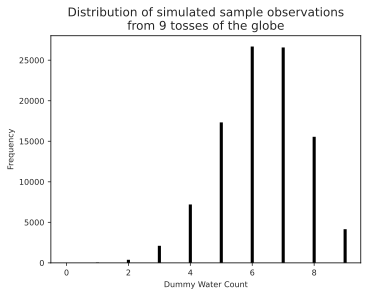

In [51]:
plt.figure(figsize=(5,4))
plt.bar(toss_count, total_counts, color='k', width=0.1)
plt.xlabel('Dummy Water Count')
plt.ylabel('Frequency')
plt.title('Distribution of simulated sample observations\nfrom 9 tosses of the globe')
plt.gca().spines[['right', 'top']].set_visible(True);

Distribution of simulated sample observations from 9 tosses of the globe. These samples assume the proportion of water is 0.7.

Notice that most of the time the expected observation does not contain water in its true proportion, 0.7. That’s the nature of observation: There is a one-to-many relationship between data and data-generating processes. You should experiment with sample size, the `n` input in the code above, as well as the `p`, to see how the distribution of simulated samples changes shape and location.

So that’s how to perform a basic simulation of observations. What good is this? There are many useful jobs for these samples. We’ll put them to use in examining the implied predictions of a model. But to do that, we’ll have to combine them with samples from the posterior distribution. That’s next.

**Sampling Distributions**:

Sampling distributions are the foundation of common non-Bayesian statistical traditions. In those approaches, inference about parameters is made through the sampling distribution. In this book, inference about parameters is never done directly through a sampling distribution. The posterior distribution is not sampled, but deduced logically. Then samples can be drawn from the posterior to aid in inference. In neither case is “sampling” a physical act. In both cases, it’s just a mathematical device and produces only *small world* numbers.

##### Model Checking

**Model checking** means (1) ensuring the model fitting worked correctly and (2) evaluating the adequacy of a model for some purpose. Since Bayesian models are always **generative**, able to simulate observations as well as estimate parameters from observations, once you condition a model on data, you can simulate to examine the model’s empirical expectations.

**Did the software work?** In the simplest case, we can check whether the software worked by checking for correspondence between implied predictions and the data used to fit the model. You might also call these implied predictions **retrodictions**, as they ask how well the model reproduces the data used to educate it. An exact match is neither expected nor desired. But when there is no correspondence at all, it probably means the software did something wrong.

There is no way to really be sure that software works correctly. Even when the retrodictions correspond to the observed data, there may be subtle mistakes. And when you start working with multilevel models, you’ll have to expect a certain pattern of lack of correspondence between retrodictions and observations. Despite there being no perfect way to ensure software has worked, the simple check I’m encouraging here often catches silly mistakes, mistakes of the kind everyone makes from time to time. In the case of the globe tossing analysis, the software implementation is simple enough that it can be checked against analytical results. So instead let’s move directly to considering the model’s adequacy

**Is the model adequate?** After assessing whether the posterior distribution is the correct one, because the software worked correctly, it’s useful to also look for aspects of the data that are not well described by the model’s expectations. The goal is not to test whether the model’s assumptions are “true,” because all models are false. Rather, the goal is to assess exactly how the model fails to describe the data, as a path towards model comprehension, revision, and improvement.

All models fail in some respect, so you have to use your judgment to decide whether any particular failure is or is not important. Few scientists want to produce models that do nothing more than re-describe existing samples. So imperfect prediction (retrodiction) is not a bad thing. Typically we hope to either predict future observations or understand enough that we might usefully tinker with the world.

For now, we need to learn how to **combine sampling of simulated observations**, with **sampling parameters from the posterior distribution**. We expect to do better when we use the entire posterior distribution, not just some point estimate derived from it. Why? Because there is a lot of information about uncertainty in the entire posterior distribution. We lose this information when we pluck out a single parameter value and then perform calculations with it. This loss of information leads to overconfidence. 

Let’s do some basic model checks, using simulated observations for the globe tossing model. The observations in our example case are counts of water, over tosses of the globe. The implied predictions of the model are uncertain in two ways, and it’s important to be aware of both.

First, there is **observation uncertainty**. For any unique value of the parameter $p$, there is a **unique implied pattern of observations** that the model expects. These patterns of observations are the same gardens of forking data that we explored in the previous chapter. These patterns are also what you sampled in the previous section. There is **uncertainty in the predicted observations**, because even if you know $p$ with certainty, you won’t know the next globe toss with certainty (unless $p =0$ or $p =1$).

Second, there is **uncertainty about $p$**. The posterior distribution over $p$ embodies this uncertainty. And since there is uncertainty about $p$, there is uncertainty about everything that depends upon $p$. The uncertainty in $p$ will interact with the **sampling variation**, when we try to assess what the model tells us about outcomes.

We’d like to **propagate** the parameter uncertainty—carry it forward—as we evaluate the implied predictions. All that is required is averaging over the posterior density for $p$, while computing the predictions. For each possible value of the parameter $p$, there is an implied distribution of outcomes. So if you were to compute the sampling distribution of outcomes at each value of $p$, then you could average all of these prediction distributions together, using the posterior probabilities of each value of p, to get a **posterior predictive distribution**.

![simulating_prediction_from_total_posterior](images/simulating_prediction_from_total_posterior.png)

![simulating_prediction_from_total_posterior](images/posterior_predictive_animation.gif)

**Simulating predictions from the total posterior** 
- *Top*: The familiar posterior distribution for the globe tossing data. Ten example parameter values are marked by the vertical lines. Values with greater posterior probability indicated by thicker lines. 
- *Middle row*: Each of the ten parameter values implies a unique sampling distribution of predictions. 
- *Bottom*: Combining simulated observation distributions for all parameter values (not just the ten shown), each weighted by its posterior probability, produces the posterior predictive distribution. This distribution propagates uncertainty about parameter to uncertainty about prediction.

In [52]:
k = 6  # Number of water
n = 9  # Binomial size (number of tosses)

# Number of samples     
size = 1e5

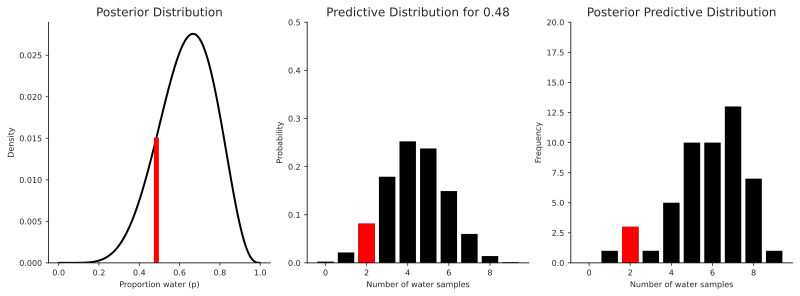

In [53]:
from matplotlib.animation import FuncAnimation

# Accumulated posterior predictive distribution
posterior_predictive = np.zeros(n + 1)                  

fig, axes = plt.subplots(1, 3, figsize=(11, 4))

# Function to update the animation for each frame
def update(frame):
    global posterior_predictive
    
    # Clear all axes for the new frame
    for ax in axes:
        ax.clear()
    
    # Grid approximation of posterior distribution with binomial likelihood
    p_grid, _, posterior  = binom_post_grid_approx(uniform_prior, grid_points=100, k=6, n=9)
    
    # Sampling parameter values from the posterior distribution
    p = np.random.choice(a=p_grid, size=1, replace=True, p=posterior)
    
    # Sample observation from Binomial distribution (n=9) for sampled p
    w = stats.binom.rvs(n, p)
    # Accumulate frequency of w
    posterior_predictive[w] += 1                    

    # Plot Posterior (prior) distribution with binomial likelihood
    axes[0].plot(p_grid, posterior, 'k-', linewidth=2)
    axes[0].set_title('Posterior Distribution')
    axes[0].set_xlabel('Proportion water (p)')
    axes[0].set_ylabel('Density')
    axes[0].set_ylim(0,)
    # Highlight the current sampled p from posterior distribution
    axes[0].vlines(x=p, ymin=0, ymax=posterior[p_grid == p], color='red', linewidth=5)

    # Sampling distribution for the current p
    binom_probs = stats.binom.pmf(np.arange(n + 1), n, p)
    axes[1].bar(np.arange(n + 1), binom_probs, color='k')        
    axes[1].set_title(f'Predictive Distribution for {p[0]:.2f}')
    axes[1].set_xlabel('Number of water samples')
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim(0,0.5)
    # Highlight the sampled water count
    axes[1].bar(w, binom_probs[w], color='red')     

    # Accumulated samples from posterior (prior) predictive distribution
    axes[2].bar(np.arange(n + 1), posterior_predictive, color='k')
    axes[2].set_title('Posterior Predictive Distribution')
    axes[2].set_xlabel('Number of water samples')
    axes[2].set_ylabel('Frequency')
    axes[2].set_ylim(0,20)
    # Highlight the current water count
    axes[2].bar(w, posterior_predictive[w], color='red') 

# Create the animation
n_frames = 50
ani = FuncAnimation(fig, update, frames=n_frames, repeat=False, interval=50)

# Save or display the animation
ani.save('images/posterior_predictive.mp4', writer='ffmpeg', fps=1)

plt.show()

The plot illustrates this averaging. At the top, the posterior distribution is shown, with 10 unique parameter values highlighted by the vertical lines. The implied distribution of observations specific to each of these parameter values is shown in the middle row of plots. Observations are never certain for any value of p, but they do shift around in response to it. Finally, at the bottom, the sampling distributions for all values of $p$ are combined, using the posterior probabilities to compute the weighted average frequency of each possible observation, zero to nine water samples.

The resulting distribution is for predictions, but it incorporates all of the uncertainty embodied in the posterior distribution for the parameter p. As a result, it is honest. While the model does a good job of predicting the data—the most likely observation is indeed the observed data—predictions are still quite spread out. If instead you were to use only a single parameter value to compute implied predictions, say the most probable value at the peak of posterior distribution, you’d produce an overconfident distribution of predictions, narrower than the posterior predictive distribution in the plot above and more like the sampling distribution shown for $p=0.6$ in the middle row. The usual effect of this overconfidence will be to lead you to believe that the model is more consistent with the data than it really is—the predictions will cluster around the observations more tightly. This illusion arises from tossing away uncertainty about the parameters.

So how do you actually do the calculations? To simulate predicted observations for a single value of $p$, say $p =0.6$, we can use `stats.binom.rvs` to generate random binomial samples. To propagate parameter uncertainty into these predictions we need to pass `samples` as `p` from the posterior:

In [54]:
n = 9
p = 0.6

p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=n)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)

w = stats.binom.rvs(n=n, p=samples)

This generates 10,000 (1e4) simulated predictions of 9 globe tosses (size=9), assuming $p=0.6$. The predictions are stored as counts of water, so the theoretical minimum is zero and the
theoretical maximum is nine.

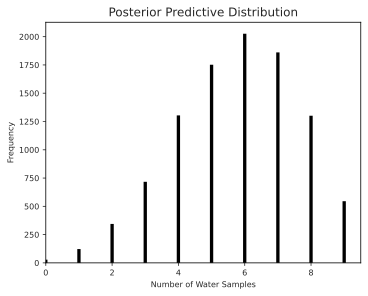

In [55]:
bar_width = 0.1

plt.figure(figsize=(5,4))
plt.hist(w, bins=np.arange(11) - bar_width / 2, width=bar_width, color='k')
plt.xlabel('Number of Water Samples')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution')
plt.xlim(0, 9.5)
plt.gca().spines[['right', 'top']].set_visible(True);

For each sampled value, a random binomial observation is generated. Since the sampled values appear in proportion to their posterior probabilities, the **resulting simulated observations are averaged over the posterior**. You can manipulate these simulated observations just like you manipulate samples from the posterior—you can compute intervals and point statistics using the same procedures.

The simulated model predictions are quite consistent with the observed data in this case—the actual count of 6 lies right in the middle of the simulated distribution. There is quite a lot of spread to the predictions, but a lot of this spread arises from the binomial process itself, not uncertainty about p. Still, it’d be premature to conclude that the model is perfect. So far, we’ve only viewed the data just as the model views it: Each toss of the globe is completely independent of the others. This assumption is questionable. Unless the person tossing the globe is careful, it is easy to induce correlations and therefore patterns among the sequential tosses. Consider for example that about half of the globe (and planet) is covered by the Pacific Ocean. As a result, water and land are not uniformly distributed on the globe, and therefore unless the globe spins and rotates enough while in the air, the position when tossed could easily influence the sample once it lands. The same problem arises in coin tosses, and indeed skilled individuals can influence the outcome of a coin toss, by exploiting the physics of it.

So with the goal of seeking out aspects of prediction in which the model fails, let’s look at the data in two different ways. Recall that the sequence of nine tosses was: `W L W W W L W L W`.

First, consider the **length of the longest run** of either water or land. This will provide a crude measure of correlation between tosses. So in the observed data, the longest run is 3 W’s. Second, consider the number of times in the data that the **sample switches** from water to land or from land to water. This is another **measure of correlation between samples**. In the observed data, the number of switches is 6. There is nothing special about these two new ways of describing the data. They just serve to inspect the data in new ways. In your own modeling, you’ll have to imagine aspects of the data that are relevant in your context, for your purposes.

In [56]:
def sim_globe(p: float, n: int) -> list[int]:
    """Simulate N globe tosses with a specific/known proportion
    p: float
        The propotion of water
    N: int
        Number of globe tosses
    
    return: a list of 1s and 0s where 1 is water and 0 is land
    """
    return np.random.choice([1,0],  size=n, p=np.array([p, 1-p]), replace=True)

def run_and_change(arr):
    diff = np.diff(arr)
    num_change = np.count_nonzero(diff)
    
    max_repeat_len = 1
    current_repeat_len = 1
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            current_repeat_len += 1
            if current_repeat_len > max_repeat_len:
                max_repeat_len = current_repeat_len
        else:
            current_repeat_len = 1
    
    return max_repeat_len, num_change

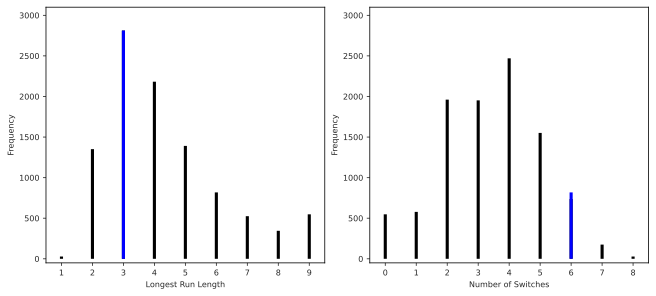

In [57]:
n = 9

longest_run = np.zeros(int(1e4))
num_switches = np.zeros(int(1e4))
for i in range(int(1e4)):
    arr = sim_globe(samples[i], n)
    longest_run[i], num_switches[i] = run_and_change(arr)

bar_width = 0.1

_, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].hist(longest_run, bins=np.arange(11) - bar_width / 2, width=bar_width, color='k')
axs[0].hist(longest_run[longest_run==3], bins=np.arange(11) - bar_width / 2, width=bar_width, color='b')
axs[0].set_xlabel('Longest Run Length')
axs[0].set_xlim(0.5,9.5)

axs[1].hist(num_switches, bins=np.arange(11) - bar_width / 2, width=bar_width, color='k')
axs[1].hist(longest_run[longest_run==6], bins=np.arange(11) - bar_width / 2, width=bar_width, color='b')
axs[1].set_xlabel('Number of Switches')
axs[1].set_xlim(-0.5,8.5)

for ax in axs:
    ax.set_ylabel('Frequency')
    ax.set_ylim(-50,3100)
    ax.spines[['right', 'top']].set_visible(True);

Alternative views of the same posterior predictive distribution from the plot earlier. Instead of considering the data as the model saw it, as a sum of water samples, now we view the data as both the length of the maximum run of water or land (left) and the number of switches between water and land samples (right). Observed values highlighted in blue. While the simulated predictions are consistent with the run length (3 water in a row), they are much less consistent with the frequent switches (6 switches in 9 tosses).

The plot shows the simulated predictions, viewed in these two new ways. On the left, the length of the longest run of water or land is plotted, with the observed value of 3 highlighted by the bold line. Again, the true observation is the most common simulated observation, but with a lot of spread around it. On the right, the number of switches from water to land and land to water is shown, with the observed value of 6 highlighted in bold. Now the simulated predictions appear less consistent with the data, as the majority of **simulated observations have fewer switches than were observed in the actual sample**. This is consistent with **lack of independence between tosses of the globe**, in which each toss is negatively correlated with the last.

Does this mean that the model is bad? That depends. The model will always be wrong in some sense, be mis-specified. But whether or not the mis-specification should lead us to try other models will depend upon our specific interests. In this case, if tosses do tend to switch from W to L and L to W, then each toss will provide less information about the true coverage of water on the globe. In the long run, even the wrong model we’ve used throughout the chapter will converge on the correct proportion. But it will do so more slowly than the posterior distribution may lead us to believe.

#### Summary

This chapter introduced the basic procedures for manipulating posterior distributions. Our fundamental tool is samples of parameter values drawn from the posterior distribution. Working with samples transforms a problem of integral calculus into a problem of data summary. These samples can be used to produce intervals, point estimates, posterior predictive checks, as well as other kinds of simulations.

Posterior predictive checks combine uncertainty about parameters, as described by the posterior distribution, with uncertainty about outcomes, as described by the assumed likelihood function. These checks are useful for verifying that your software worked correctly. They are also useful for prospecting for ways in which your models are inadequate.

Once models become more complex, posterior predictive simulations will be used for a broader range of applications. Even understanding a model often requires simulating implied observations. We’ll keep working with samples from the posterior, to make these tasks as easy and customizable as possible.

#### Practice Problems

The Easy problems use the samples from the posterior distribution for the globe tossing example. This code will give you a specific set of samples, so that you can check your answers exactly.

Use the values in `samples` to answer the questions that follow.

In [58]:
k = 6
n = 9
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=k, n=n)

np.random.seed(100)
samples = np.random.choice(a=p_grid, size=int(1e4), replace=True, p=posterior)

1) How much posterior probability lies below $p=0.2$?

To find out how much posterior probability lies below p =0.2, just compute the proportion of samples that are below 0.2. First, count up how many samples are below 0.2:

In [59]:
np.sum(samples < 0.2)

10

Only 5 samples have a value less than 0.2. Now to compute the proportion, just divide by the number of samples:

In [60]:
np.sum(samples < 0.2)/1e4

0.001

2. How much posterior probability lies above $p=0.8$?

In [61]:
np.sum(samples > 0.8)/1e4

0.1209

3. How much posterior probability lies between $p =0.2$ and $p =0.8$?

In [62]:
np.sum((samples > 0.2) & (samples < 0.8))/1e4

0.8781

4. 20% of the posterior probability lies below which value of $p$?

This problem asks for an interval of defined mass, so we need to find the boundary.

In [63]:
np.quantile(samples, q=0.2)

0.5155155155155156

So $p =0.52$ (rounding for sanity) is the value that 20% of the posterior probability lies below. You can confirm this by going in the other direction:

In [64]:
np.sum(samples < 0.52) / 1e4

0.2092

5. 20% of the posterior probability lies above which value of p?

A slight modification to the quantile code from earlier will do it. The trick here is to realize that finding the value of p above which 20% of the posterior probability lies means asking for the 80% quantile. Why? Because only 20% of the probability mass remains above 80%. 

In [65]:
np.quantile(samples, q=0.8)

0.7597597597597597

Again, you can verify that this is correct by doing the calculation in reverse:

In [66]:
np.sum(samples > 0.76) / 1e4

0.1997

Not exactly 0.2, but that’s just because of the discrete nature of the grid we used, as well as the finite number of samples.

6. Which values of $p$ contain the narrowest interval equal to 66% of the posterior probability?

This problem is asking for a highest posterior density interval (HDPI)

In [67]:
az.hdi(samples, hdi_prob=0.66)

array([0.51651652, 0.78878879])

7. Which values of $p$ contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

This problem is asking instead for a conventional percentile interval.

In [68]:
np.quantile(samples, [0.17, 0.66])

array([0.4984985, 0.7017017])

Note that this interval is, as expected, a little wider than the corresponding HPDI from the previous problem. If this isn’t obvious at a glance, you can just compute the width of the intervals

8. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

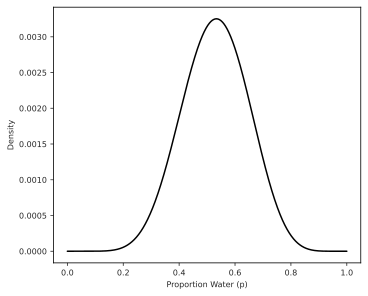

In [69]:
k = 8
n = 15
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=k, n=n)

plt.figure(figsize=(5,4))
plt.plot(p_grid, posterior)
plt.xlabel('Proportion Water (p)')
plt.ylabel('Density')
plt.gca().spines[['right', 'top']].set_visible(True)

9. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for $p$.

In [70]:
np.random.seed(100)
samples = np.random.choice(p_grid, size=10_000, p=posterior, replace=True)

az.hdi(samples, hdi_prob=0.9)

array([0.33733734, 0.72572573])

10. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in $p$. What is the probability of observing 8 water in 15 tosses?

In [71]:
w = stats.binom.rvs(n=n, p=samples)
toss_count, total_counts = np.unique(w, return_counts=True)

table = PrettyTable()
table.field_names = np.append(['W'], toss_count)
table.add_row(np.append(['Total Count'], total_counts))
table.add_row(np.append(['Proportion'], total_counts/1e4))
table

W,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Total Count,4,34,118,281,530,838,1130,1370,1458,1372,1158,849,512,243,89,14
Proportion,0.0004,0.0034,0.0118,0.0281,0.053,0.0838,0.113,0.137,0.1458,0.1372,0.1158,0.0849,0.0512,0.0243,0.0089,0.0014


What does this number mean? Not much. Any particular set of data can be unlikely, so discrete probabilities of data are hardly ever useful for summarize model fit. It’s more common to summarize model fit using tail-area probabilities, for this reason. But those aren’t always sensible either. In this case, it may be enough to confirm that the observed value 8 is right in the middle of the posterior predictive distribution. Plot it to confirm:

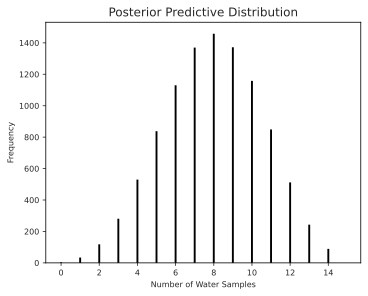

In [72]:
bar_width = 0.1

plt.figure(figsize=(5,4))
plt.hist(w, bins=np.arange(16) - bar_width / 2, width=bar_width)
plt.xlabel('Number of Water Samples')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution')
# plt.xlim(0, 15.5)
plt.gca().spines[['right', 'top']].set_visible(True);

This doesn’t mean it is a good model. But it does mean that model fitting worked.

11. Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [73]:
w = stats.binom.rvs(n=9, p=samples)
toss_count, total_counts = np.unique(w, return_counts=True)

table = PrettyTable()
table.field_names = np.append(['W'], toss_count)
table.add_row(np.append(['Total Count'], total_counts))
table.add_row(np.append(['Proportion'], total_counts/1e4))
table

W,0,1,2,3,4,5,6,7,8,9
Total Count,53,277,765,1408,1973,2026,1729,1114,528,127
Proportion,0.0053,0.0277,0.0765,0.1408,0.1973,0.2026,0.1729,0.1114,0.0528,0.0127


12. Start over at question 8, but now use a prior that is zero below $p=0.5$ and a constant above $p=0.5$. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value $p=0.7$.

In [74]:
def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)

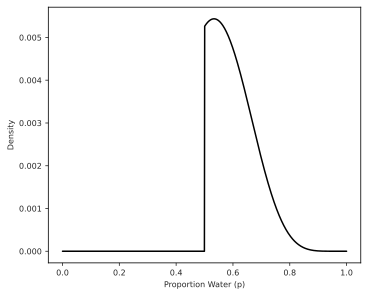

In [75]:
k = 8
n = 15
p_grid, _, posterior = binom_post_grid_approx(truncated_prior, grid_points=1_000, k=k, n=n)

plt.figure(figsize=(5,4))
plt.plot(p_grid, posterior)
plt.xlabel('Proportion Water (p)')
plt.ylabel('Density')
plt.gca().spines[['right', 'top']].set_visible(True)

The 90% HPDI will be a lot narrower now:

In [76]:
np.random.seed(100)
samples = np.random.choice(p_grid, size=10_000, p=posterior, replace=True)

az.hdi(samples, hdi_prob=0.9)

array([0.5005005 , 0.71271271])

It is narrower, just because the prior tells the model to ignore all values of p below 0.5. Prior information makes those values impossible causes of the data.

When re-simulating the posterior predictive distributions, note that the observed value of 8 water is no longer right in the center of the distribution. For example:

In [77]:
w = stats.binom.rvs(n=n, p=samples)
toss_count, total_counts = np.unique(w, return_counts=True)

table = PrettyTable()
table.field_names = np.append(['W'], toss_count)
table.add_row(np.append(['Total Count'], total_counts))
table.add_row(np.append(['Proportion'], total_counts/1e4))
table

W,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Total Count,1,11,47,123,339,692,1151,1569,1770,1634,1265,839,394,140,25
Proportion,0.0001,0.0011,0.0047,0.0123,0.0339,0.0692,0.1151,0.1569,0.177,0.1634,0.1265,0.0839,0.0394,0.014,0.0025


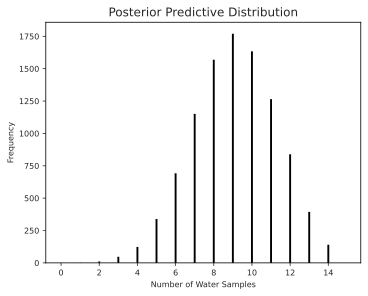

In [78]:
bar_width = 0.1

plt.figure(figsize=(5,4))
plt.hist(w, bins=np.arange(16) - bar_width / 2, width=bar_width)
plt.xlabel('Number of Water Samples')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution')
plt.gca().spines[['right', 'top']].set_visible(True);

The informative prior tells the model not to completely trust the data, so it shouldn’t be surprising that the simulated posterior sampling distributions are not centered on the data. This is not an indication of anything wrong with the model. It’s merely a consequence of the model.

When you reach multilevel models in the late chapters, you will have to expect mismatch between predictions and data in this way, because multilevel models often have informative priors. Informative priors are what make them good models.

13. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of $p$ to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

For this we can perform a simulation study. Let's assume we have the uniform prior on our model, and that the data has a binomial likelihood, as in the earlier questions. We can simulate data according to true underlying values of $p$. We can keep tossing the globe until our 99% percentile intervals have a width smaller than 0.05, at which point we'll stop tossing, and take note of how many trials it took for the intervals to converge. As this number of trials is going to be stochastic for each run, we repeat the runs 100 times and take the mean of the number trials to get an estimate of the number of trials required. We then repeat this for different hypothetical values of the underlying parameter $p$, to see how the number of trials required varies with the parameter.

In [79]:
grid = np.linspace(0, 1, 10)  # define a grid of ground truth values

trials_for_p = []

for p in grid:
    num_trials = []
    for i in range(100):
        n, x = 0, 0  # initialise # samples and # successful trials
        interval = (0.005, 0.995)  # initialise the interval to the flat prior
        while interval[1] - interval[0] > 0.05:
            x += np.random.binomial(1, p)  # perform trial
            n += 1  # add counts
            interval = stats.beta.interval(0.99, x + 1, n - x + 1)  # percentile interval
        num_trials.append(n)
    mean = np.array(num_trials).mean()
    trials_for_p.append(mean)

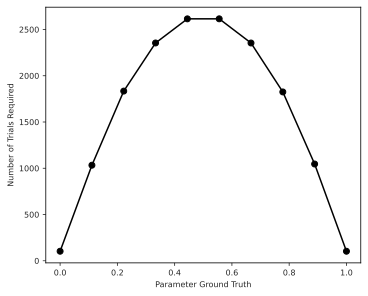

In [80]:
plt.figure(figsize=(5,4))
plt.plot(grid, trials_for_p, 'o-')
plt.ylabel("Number of Trials Required")
plt.xlabel("Parameter Ground Truth")
plt.gca().spines[['right', 'top']].set_visible(True);

#### PyMC Implementation

As before, set the prior to be the uniform and the likelihood to be the binomial. The data given in the book is the set of outcomes `W L W W W L W L W`, which I'll give a binary representation in the same order.

Pymc3 nicely allows you to state the prior and the likelihood function of the data. You can use its `pm.sample` function in order to obtain a random sample from the posterior distribution. This is done using MCMC techniques, but they aren't introduced until later in Statistical rethinking. You can run "chains" of the sampling procedure to sanity check the MCMC methods that took place. The samples from the posterior distribution are also returned and we can perform inference on the posterior according to this.

In [81]:
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


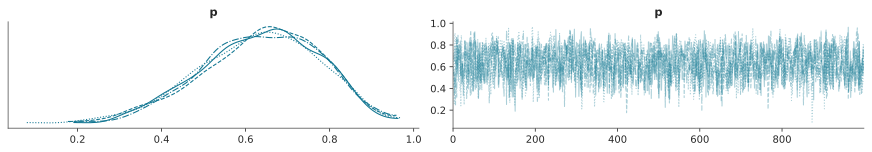

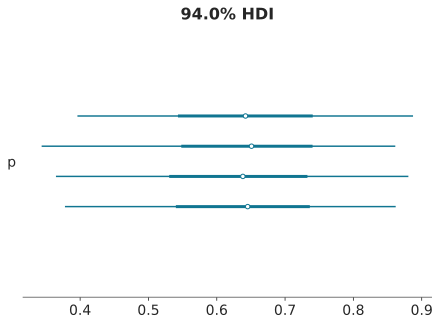

In [92]:
with pm.Model() as our_first_model:
    p = pm.Uniform("p")  # set the prior
    y = pm.Bernoulli("y", p=p, observed=data)  # set the posterior
    trace = pm.sample(1000, chains=4)  # get 1000 random_samples
    az.plot_trace(trace, compact=True)
    az.plot_forest(trace, var_names=["p"])

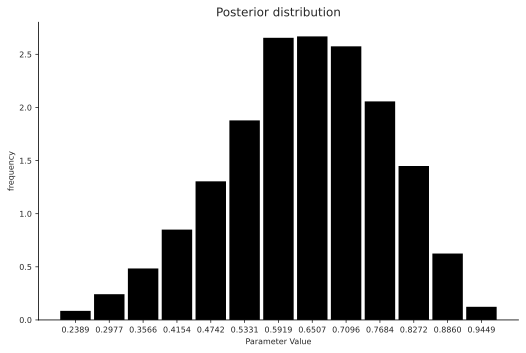

In [83]:
# plot the posterior
az.plot_dist(trace["posterior"]['p'], kind='hist')
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

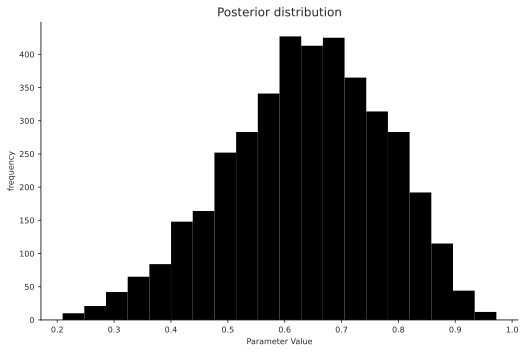

In [84]:
# plot the posterior
plt.hist(trace["posterior"]['p'].to_numpy().flatten(), bins=20)
plt.title("Posterior distribution") 
plt.ylabel("frequency")
plt.xlabel("Parameter Value");